# HeAR Embeddings with (Pre-processed) VocalSound Audio

This notebook demonstrates how to use the HeAR (Health Acoustic Representations) model, directly from Hugging Face, to create and utilize embeddings from VocalSound: an open-source dataset for human health sounds. Here we use the preprocessed data in audio/audio_processed. Check out the Audio_Preprocessing.ipynb notebook to see the processing pipeline.

Embeddings are compact, numerical representations of audio data that capture important features, making them suitable for training machine learning models with limited data and computational resources. The goal is to cluster these embeddings using t-SNE to a 2-dimensional grid, which we can visualize.

#### Here's a breakdown of the notebook's steps:

1.  **Model Loading:** The HeAR model is loaded from the Hugging Face Hub (requires authentication with your Hugging Face account).

2.  **Dataset Loading:**
    *   **VocalSound Audio:** A set of pre-processed audio clips from VocalSound is loaded from audio/audio_processed. This dataset includes six human health sounds (sigh, cough, throatclearing, sneeze, sniff, laughter) from a variety of individuals.

3.  **Embedding Generation:**
    *   **Preprocessing:** The downloaded audio files are and processed using `librosa`. They are padded to 2-second clips.
    *   **Testing:** A small subset of preprocessed audio clips are fed to the HeAR model to generate embeddings. A plot visualizing the data points in a PCA space is presented as a naive clustering.
    *   **Inference:** All 20662 preprocessed 2-second audio clips are fed to the HeAR model to generate embeddings. Each clip produces a 512-dimensional HeAR embedding vector.

**Note**: This notebook was heavily taken from https://github.com/Google-Health/hear/blob/master/notebooks/train_data_efficient_classifier.ipynb. All credit to Google Health.

In [80]:
# @title Import Statements

import os
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import matplotlib.cm as cm
import warnings
import csv
from sklearn.decomposition import PCA
import glob
import numpy as np
import pandas as pd
import time
import random
from scipy.spatial import distance

## Setup HeAR Hugging Face Model

### Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

In [1]:
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

### Load Model from Hugging Face

In [60]:
# HeAR Parameters
SAMPLE_RATE = 16000  # Samples per second (Hz)
CLIP_DURATION = 2    # Duration of the audio clip in seconds
EMBEDDING_DIMENSION = 512 # Length of the embedding vector
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION  # Total number of samples
METADATA_PATH = 'vs_release_16k/meta/all_meta.csv'

In [ ]:
from huggingface_hub import from_pretrained_keras

# Load the model directly from Hugging Face Hub
loaded_model = from_pretrained_keras("google/hear")
# Inference function for embedding generation
infer = loaded_model.signatures["serving_default"]


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

ValueError: File format not supported: filepath=/Users/hishambhatti/.cache/huggingface/hub/models--google--hear/snapshots/9b2eb2853c426676255cc6ac5804b7f1fe8e563f. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/Users/hishambhatti/.cache/huggingface/hub/models--google--hear/snapshots/9b2eb2853c426676255cc6ac5804b7f1fe8e563f, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Run the model on a randomly generated audio input

In [4]:
import keras
import numpy as np

# Path to cached model (Hugging Face auto-downloads it)
model_path = "/Users/hishambhatti/.cache/huggingface/hub/models--google--hear/snapshots/9b2eb2853c426676255cc6ac5804b7f1fe8e563f"

# Load as a Keras layer wrapping the SavedModel
hear_layer = keras.layers.TFSMLayer(model_path, call_endpoint="serving_default")

# Configure parameters
SAMPLE_RATE = 16000
CLIP_DURATION = 2
CLIP_LENGTH = SAMPLE_RATE * CLIP_DURATION

In [5]:
import numpy as np
import time

NUM_EXAMPLES = 4
print(f"Generating {NUM_EXAMPLES} {CLIP_DURATION}s raw audio examples.")
raw_audio = np.random.normal(size=(NUM_EXAMPLES, CLIP_LENGTH))
print(f"Raw audio shape: {raw_audio.shape}, dtype: {raw_audio.dtype}\n")

print(f'Running HeAR model to produce {NUM_EXAMPLES} embeddings.')
start = time.time()
embedding_dict = hear_layer(raw_audio)        # TFSMLayer inference
embedding_tensor = embedding_dict['output_0']
embedding_np = embedding_tensor.numpy()         # convert to NumPy
end = time.time()

print(f"Embedding shape: {embedding_np.shape}, dtype: {embedding_np.dtype}")
print("Elapsed:", end - start, "seconds")

Generating 4 2s raw audio examples.
Raw audio shape: (4, 32000), dtype: float64

Running HeAR model to produce 4 embeddings.


2025-10-23 20:45:37.791575: I external/local_xla/xla/service/service.cc:163] XLA service 0xb3d9a2400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-23 20:45:37.791593: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1761277539.632807  111173 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Embedding shape: (4, 512), dtype: float32
Elapsed: 2.837913990020752 seconds


## Generate Embeddings

In [13]:
def plot_waveform(sound, sr, title, figsize=(12, 4), color='blue', alpha=0.7):
  """Plots the waveform of the audio using librosa.display."""
  plt.figure(figsize=figsize)
  librosa.display.waveshow(sound, sr=sr, color=color, alpha=alpha)
  plt.title(f"{title}\nshape={sound.shape}, sr={sr}, dtype={sound.dtype}")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.grid(True)
  plt.tight_layout()
  plt.show()


def plot_spectrogram(sound, sr, title, figsize=(12, 4), n_fft=2048, hop_length=256, n_mels=128, cmap='nipy_spectral', vmin=-30, vmax=0):
  """Plots the Mel spectrogram of the audio using librosa."""
  plt.figure(figsize=figsize)
  mel_spectrogram = librosa.feature.melspectrogram(y=sound, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
  librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(f"{title} - Mel Spectrogram")
  plt.tight_layout()
  plt.show()

Build a metadata dictionary

e.g. 'f0003' -> {'id': 'f0003', 'gender': ' female', 'age': '56', 'native_language': ' United States of America', 'country': ' EN', 'health': ' no'}

In [31]:
metadata_map = {}
with open('vs_release_16k/meta/all_meta.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=['id', 'gender', 'age', 'native_language', 'country', 'health'])
    # Skip the first row if it's a header or description you don't need
    # next(reader)
    for row in reader:
        # The key is the speaker ID (e.g., 'f0003', 'm1411')
        metadata_map[row['id']] = row

# Print example mapping
print(metadata_map['f0003'])

{'id': 'f0003', 'gender': ' female', 'age': '56', 'native_language': ' United States of America', 'country': ' EN', 'health': ' no'}


### HeAR embeddings for small set of VocalSound audio clips

#### Generate Embeddings


Loading file: f0003_0_sigh from audio/audio_processed/f0003_0_sigh.wav


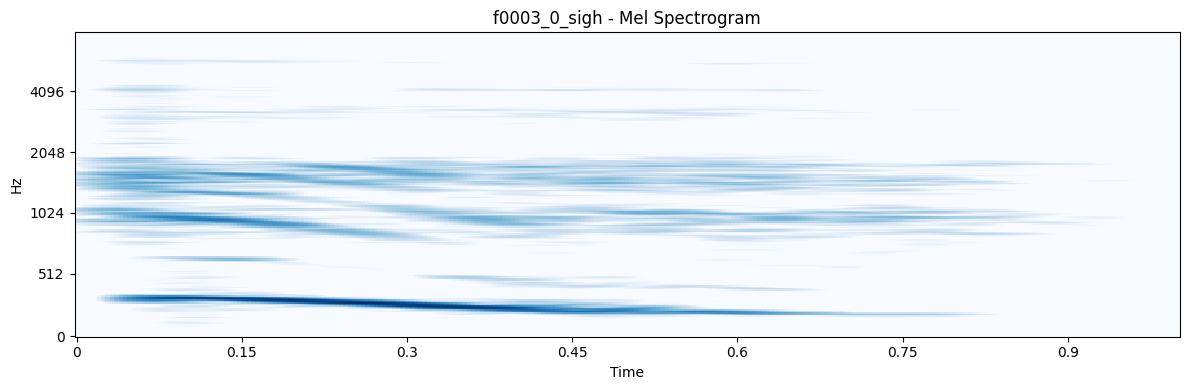

  Clip not in cache, performing inference...
Elapsed: 0.19821786880493164 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_cough from audio/audio_processed/m1411_0_cough.wav


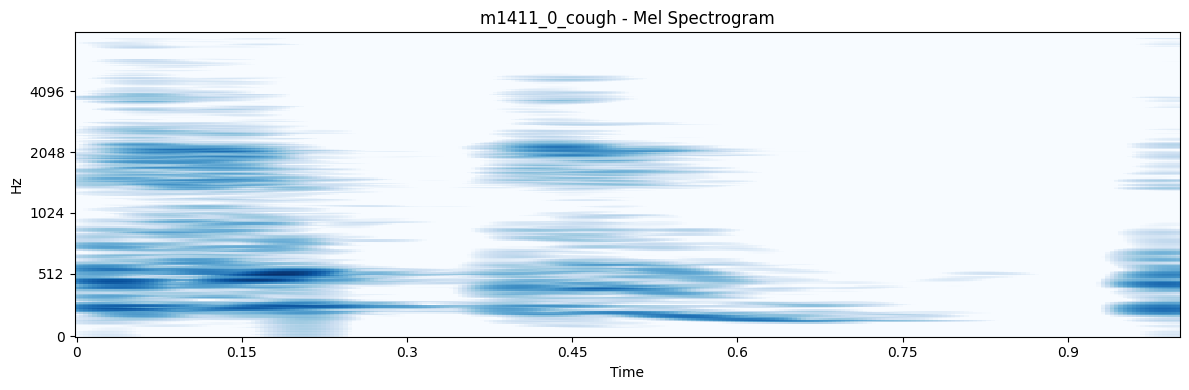

  Clip not in cache, performing inference...
Elapsed: 0.22259211540222168 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: f0003_0_cough from audio/audio_processed/f0003_0_cough.wav


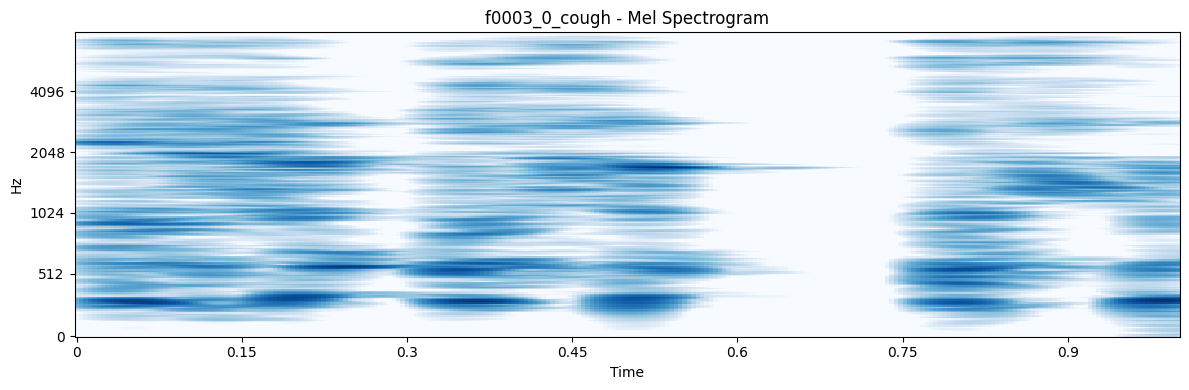

  Clip not in cache, performing inference...
Elapsed: 0.2116260528564453 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: f0003_0_sniff from audio/audio_processed/f0003_0_sniff.wav


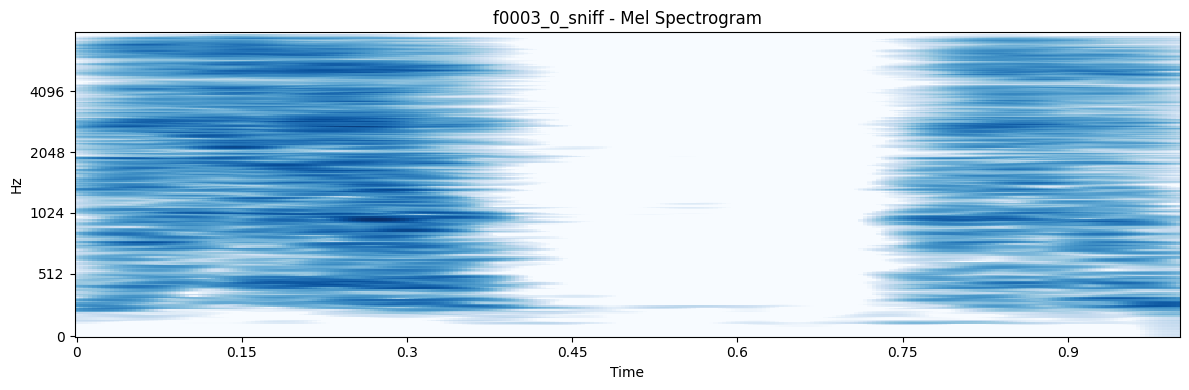

  Clip not in cache, performing inference...
Elapsed: 0.24470090866088867 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: f0003_0_throatclearing from audio/audio_processed/f0003_0_throatclearing.wav


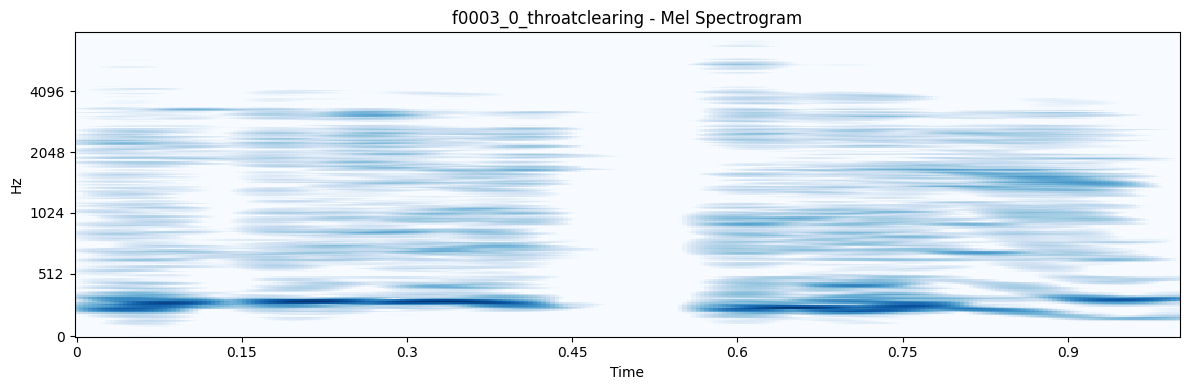

  Clip not in cache, performing inference...
Elapsed: 0.21386408805847168 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: f0003_0_sneeze from audio/audio_processed/f0003_0_sneeze.wav


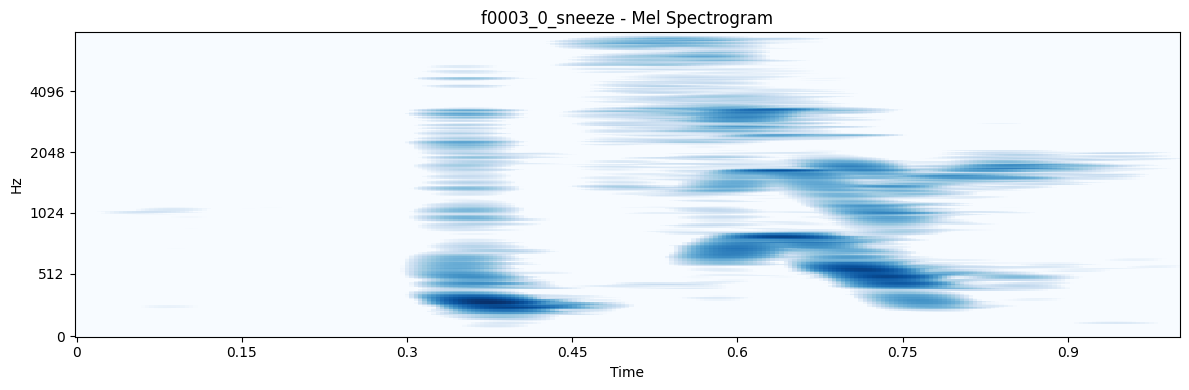

  Clip not in cache, performing inference...
Elapsed: 0.21434807777404785 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_sigh from audio/audio_processed/m1411_0_sigh.wav


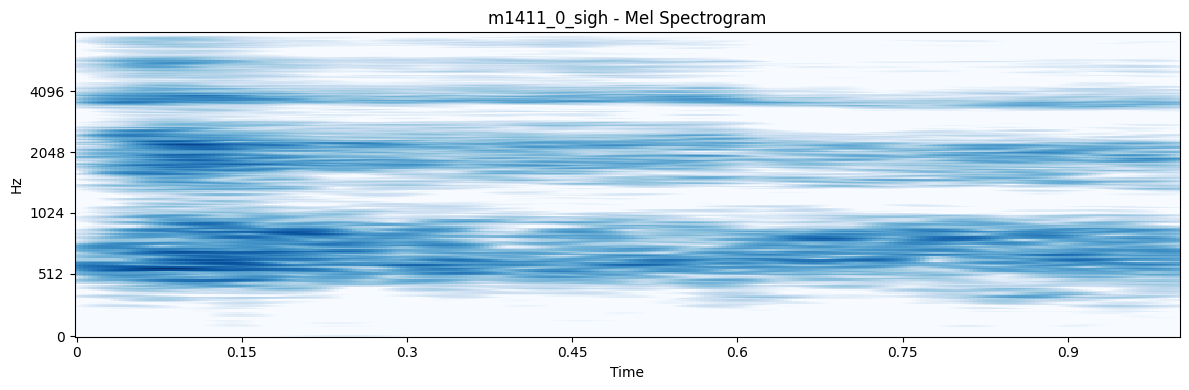

  Clip not in cache, performing inference...
Elapsed: 0.28041505813598633 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_throatclearing from audio/audio_processed/m1411_0_throatclearing.wav


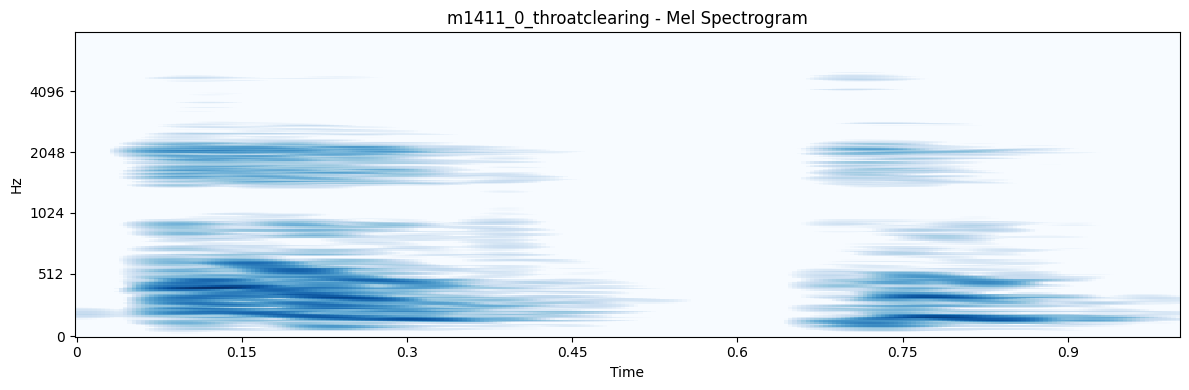

  Clip not in cache, performing inference...
Elapsed: 0.21460294723510742 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_laughter from audio/audio_processed/m1411_0_laughter.wav


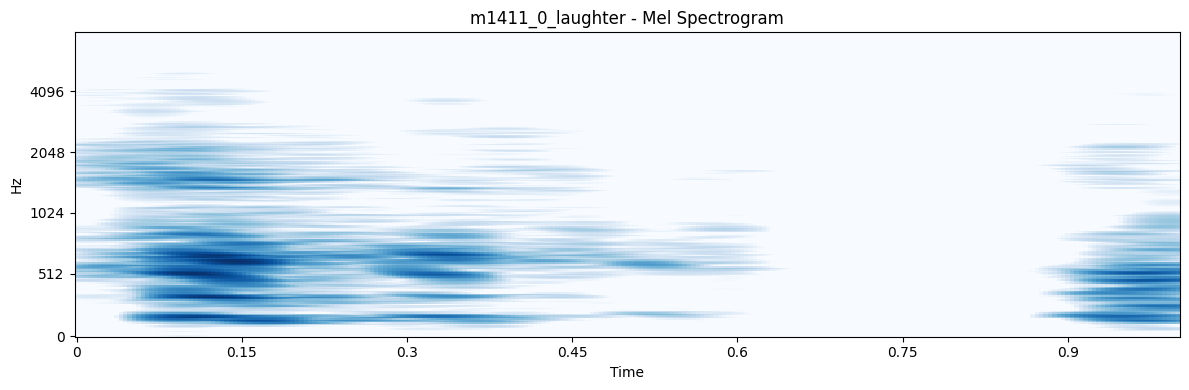

  Clip not in cache, performing inference...
Elapsed: 0.24696087837219238 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: f0003_0_laughter from audio/audio_processed/f0003_0_laughter.wav


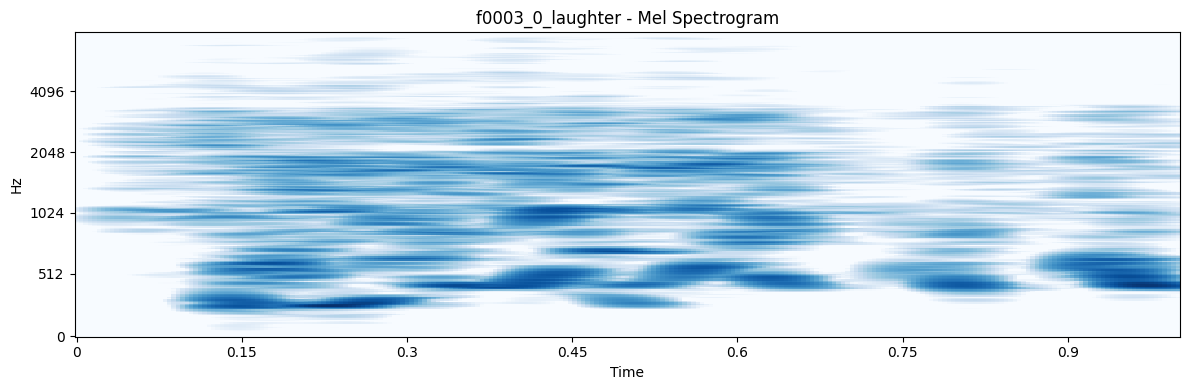

  Clip not in cache, performing inference...
Elapsed: 0.20712780952453613 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_sneeze from audio/audio_processed/m1411_0_sneeze.wav


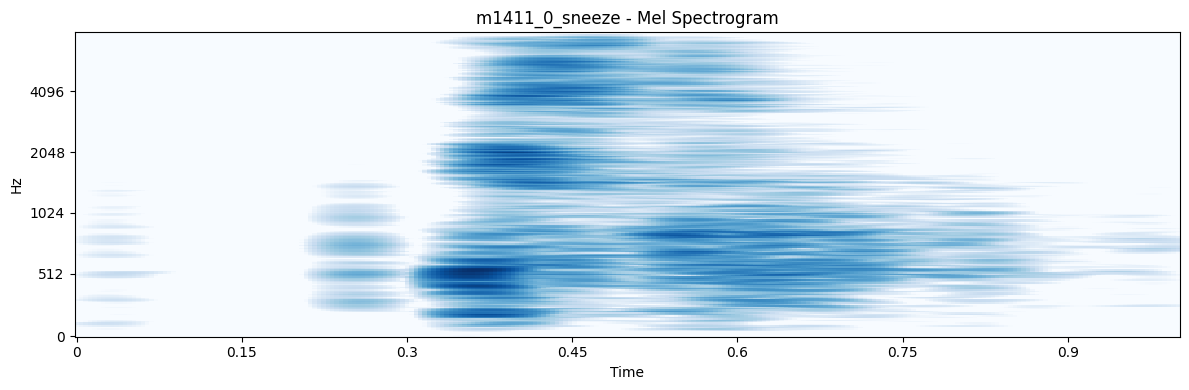

  Clip not in cache, performing inference...
Elapsed: 0.24809503555297852 seconds
  Embedding batch shape: (1, 512), data type: float32

Loading file: m1411_0_sniff from audio/audio_processed/m1411_0_sniff.wav


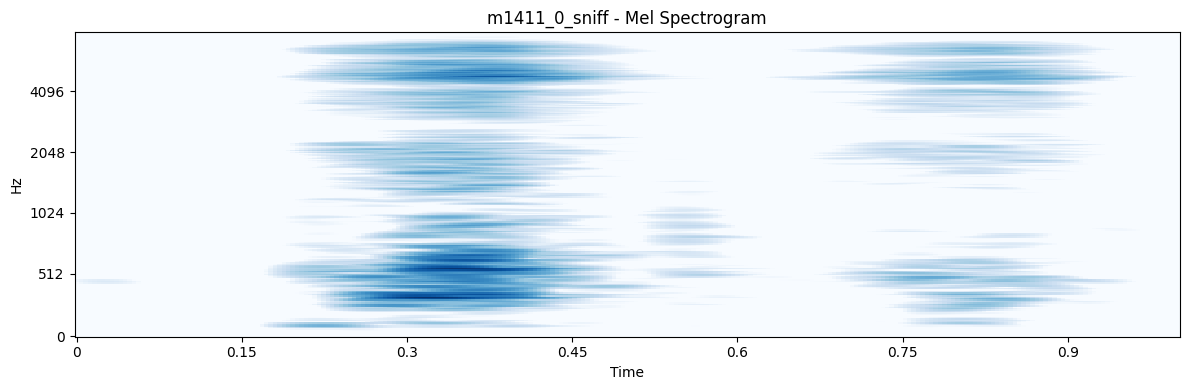

  Clip not in cache, performing inference...
Elapsed: 0.21168184280395508 seconds
  Embedding batch shape: (1, 512), data type: float32


In [17]:
# Cache to store embeddings for files
file_embeddings = {}

# Audio display options
SHOW_WAVEFORM = False
SHOW_SPECTROGRAM = True
SHOW_PLAYER = True
SHOW_CLIPS = False

file_set = {'f0003_0_cough', 'f0003_0_laughter', 'f0003_0_sigh', 'f0003_0_sneeze',
            'f0003_0_sniff', 'f0003_0_throatclearing', 'm1411_0_cough',
            'm1411_0_laughter', 'm1411_0_sigh', 'm1411_0_sneeze', 'm1411_0_sniff',
            'm1411_0_throatclearing'}

for file in file_set:
  file_url = f'audio/audio_processed/{file}.wav'
  # Load the audio file into numpy array with specified sample rate and 1 channel (mono).
  print(f"\nLoading file: {file} from {file_url}")
  audio, sample_rate = librosa.load(file_url, sr=SAMPLE_RATE, mono=True)

  # Display audio file (optional)
  if SHOW_WAVEFORM:
    plot_waveform(audio, sample_rate, title=file, color='blue')
  if SHOW_SPECTROGRAM:
    plot_spectrogram(audio, sample_rate, file,  n_fft=2*1024, hop_length=64, n_mels=256, cmap='Blues', vmax=0, vmin=-40)
  if SHOW_PLAYER:
    display(Audio(data=audio, rate=sample_rate))

  # Pads clip with zeros
  clip = np.pad(audio, (0, CLIP_LENGTH - len(audio)), 'constant')
  clip_batch = [clip]

  if SHOW_CLIPS and SHOW_PLAYER:
      display(Audio(data=clip, rate=sample_rate))

  # Perform HeAR Batch inference to extract the associated clip embedding.
  # Only run inference if embedding not already in file_embedding cache.
  clip_batch = np.asarray(clip_batch)
  if file not in file_embeddings:
    print("  Clip not in cache, performing inference...")

    start = time.time()
    embedding_batch = hear_layer(clip_batch)['output_0'].numpy()
    end = time.time()
    print("Elapsed:", end - start, "seconds")
    file_embeddings[file] = embedding_batch
  else:
    embedding_batch = file_embeddings[file]
  print(f"  Embedding batch shape: {embedding_batch.shape}, data type: {embedding_batch.dtype}")



Display information about embeddings

In [18]:
embeddings, file_names = [], []
for file, embedding_batch in file_embeddings.items():
  for embedding in embedding_batch:
      embeddings.append(embedding)
      file_names.append(file)
embeddings = np.array(embeddings)

print(f"Embeddings have shape: {embeddings.shape}, data type: {embeddings.dtype}")
print(f"Embeddings are from {len(file_set)} unique files:{file_set}")

Embeddings have shape: (12, 512), data type: float32
Embeddings are from 12 unique files:{'f0003_0_sigh', 'm1411_0_cough', 'f0003_0_cough', 'f0003_0_sniff', 'f0003_0_throatclearing', 'f0003_0_sneeze', 'm1411_0_sigh', 'm1411_0_throatclearing', 'm1411_0_laughter', 'f0003_0_laughter', 'm1411_0_sneeze', 'm1411_0_sniff'}


#### Visualize Embeddings

We use PCA to visualize embeddings

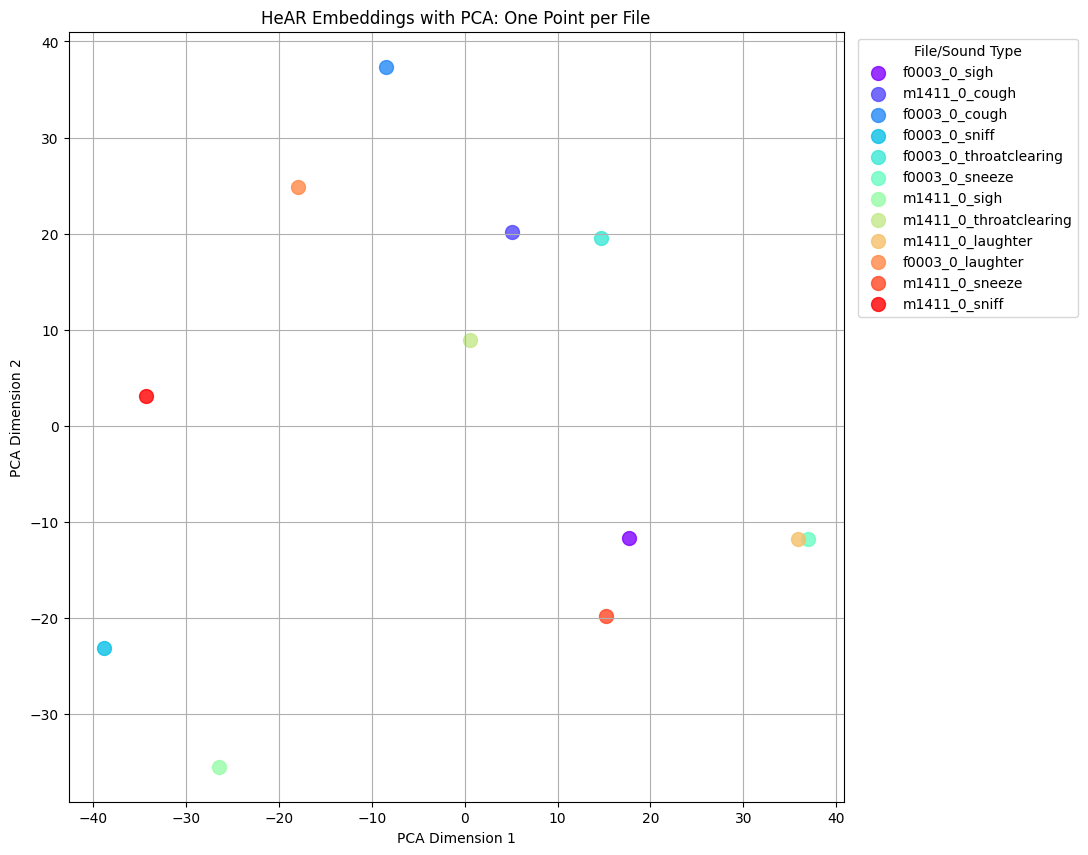

In [ ]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
colors = cm.rainbow(np.linspace(0, 1, len(file_set)))
color_map = {key: colors[i] for i, key in enumerate(file_set)}

pca_points_by_file = {file: None for file in file_set}

# file_names[i] corresponds directly to pca_embeddings[i]
for i, file_key in enumerate(file_names):
    pca_points_by_file[file_key] = pca_embeddings[i]

# Plot the single point per file (and generating the legend)
for file_key in file_set:
    point = pca_points_by_file.get(file_key)
    if point is not None:
        # Plot the single point for this file.
        # The 'label' is used here to correctly create ONE legend entry per file type.
        plt.scatter(point[0], point[1],
                    color=color_map[file_key],
                    alpha=0.8,
                    s=100,
                    label=file_key,
                    marker='o')

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("HeAR Embeddings with PCA")
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), title="File/Sound Type")
plt.grid(True)
plt.show()

Notice that this does not seem to be a strong embedding scheme, as many audio clips with the same sound type far away from each other in space. This calls for t-SNE.

### HeAR Embedding for ALL Audio

In [36]:
# Audio display options (disabled)
SHOW_WAVEFORM = False
SHOW_SPECTROGRAM = False
SHOW_PLAYER = False
SHOW_CLIPS = False

# Find all audio files
AUDIO_DIR = 'audio/audio_processed'
all_file_paths = glob.glob(os.path.join(AUDIO_DIR, '*.wav'))
print(f"Found {len(all_file_paths)} audio files in the dataset.")

all_embeddings = []
all_metadata_rows = []

start_total_time = time.time()
file_embeddings_cache = {} # Use this to avoid re-running inference on the same file in one session

for i, file_path in enumerate(all_file_paths):
    # Basename extracts the folders, e.g. audio/audio_processed/f1236_0_sigh.wav --> f1236_0_sigh
    base_file_name = os.path.basename(file_path).replace('.wav', '')

    try:
        parts = base_file_name.split('_')
        speaker_id = parts[0]
        sound_type = parts[-1] # 'cough', 'laughter', etc.
        speaker_metadata = metadata_map.get(speaker_id, {})
    except IndexError:
        print(f"Skipping malformed filename: {base_file_name}")
        continue

    # Checkpoint every 1000 iterations
    if i % 1000 == 0:
        print(f"\nProcessing file {i}/{len(all_file_paths)}: {base_file_name}")
    print(file_path)

    # Load audio
    audio, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    # Display audio file (optional)
    if SHOW_WAVEFORM:
        plot_waveform(audio, sample_rate, title=file, color='blue')
    if SHOW_SPECTROGRAM:
        plot_spectrogram(audio, sample_rate, file,  n_fft=2*1024, hop_length=64, n_mels=256, cmap='Blues')
    if SHOW_PLAYER:
        display(Audio(data=audio, rate=sample_rate))

    clip = np.pad(audio, (0, CLIP_LENGTH - len(audio)), 'constant')

    if SHOW_CLIPS and SHOW_PLAYER:
        display(Audio(data=clip, rate=sample_rate))

    clip_batch = np.asarray([clip])

    if base_file_name not in file_embeddings_cache:
        ## THIS IS WHERE WE ACTUALLY RUN THE HEAR MODEL
        embedding = hear_layer(clip_batch)['output_0'].numpy()
        file_embeddings_cache[base_file_name] = embedding
    else:
        embedding = file_embeddings_cache[base_file_name]

    # Shape of embedding_batch is (num_clips, embedding_dimension)
    all_embeddings.append(embedding)

    # Create a single dictionary row with all relevant information
    metadata_row = {
        'file_name': base_file_name,
        'sound_type': sound_type,
        'clip_count': len(clip_batch),
        'speaker_id': speaker_id,
        **speaker_metadata # Merge speaker-level metadata
    }
    all_metadata_rows.append(metadata_row)

end_total_time = time.time()
print("\n" + "="*50)
print(f"Total time for processing all files: {end_total_time - start_total_time:.2f} seconds.")
print(f"Successfully processed and embedded {len(all_embeddings)} files.")
print(f"Final Embeddings Array Shape: ({len(all_embeddings)}, {EMBEDDING_DIMENSION})")
print("="*50)

# Finalize and Save to Disk ---

# Convert lists to final NumPy array and Pandas DataFrame
final_embeddings_np = np.array(all_embeddings)
final_metadata_df = pd.DataFrame(all_metadata_rows)

# Define file names for saving
EMBEDDINGS_FILE = 'vocalsound_processed_hear_embeddings.npy'
METADATA_FILE = 'vocalsound_processed_hear_metadata.csv'

# Save the large NumPy array (embeddings)
np.save(EMBEDDINGS_FILE, final_embeddings_np)
print(f"Saved embeddings to: {EMBEDDINGS_FILE}")

# Save the metadata (file_name, sound_type, speaker info)
final_metadata_df.to_csv(METADATA_FILE, index=False)
print(f"Saved metadata to: {METADATA_FILE}")

Found 20662 audio files in the dataset.

Processing file 0/20662: f1236_0_sigh
audio/audio_processed/f1236_0_sigh.wav
audio/audio_processed/f1541_0_throatclearing.wav
audio/audio_processed/m1679_0_sniff.wav
audio/audio_processed/m1783_0_throatclearing.wav
audio/audio_processed/f1291_0_laughter.wav
audio/audio_processed/m0209_0_sneeze.wav
audio/audio_processed/f1284_0_laughter.wav
audio/audio_processed/m1037_0_sigh.wav
audio/audio_processed/m0019_0_cough.wav
audio/audio_processed/f2769_0_laughter.wav
audio/audio_processed/m1329_0_sniff.wav
audio/audio_processed/m2930_0_throatclearing.wav
audio/audio_processed/f2769_0_sniff.wav
audio/audio_processed/f1956_2_sneeze.wav
audio/audio_processed/f0998_0_laughter.wav
audio/audio_processed/m2523_0_laughter.wav
audio/audio_processed/m2536_0_laughter.wav
audio/audio_processed/f2899_0_sniff.wav
audio/audio_processed/f1216_0_sneeze.wav
audio/audio_processed/m1528_0_sigh.wav
audio/audio_processed/f2985_0_throatclearing.wav
audio/audio_processed/m1770

## Load & Test Embeddings

### Load the embeddings from disk

In [56]:
EMBEDDINGS_FILE = 'vocalsound_processed_hear_embeddings.npy'
METADATA_FILE = 'vocalsound_processed_hear_metadata.csv'

embeddings = np.load(EMBEDDINGS_FILE) # Loads (20662, 1, 512)
embeddings = np.squeeze(embeddings, axis=1) # Removes the middle dimension
print(f"Loaded embeddings. Shape: {embeddings.shape}")

metadata_df = pd.read_csv(METADATA_FILE)
print(f"Loaded metadata. Shape: {metadata_df.shape}")

# Sanity Check: Ensure the number of embeddings matches the number of metadata rows
if embeddings.shape[0] != metadata_df.shape[0]:
    print(f"WARNING: Mismatch between embeddings ({embeddings.shape[0]}) and metadata ({metadata_df.shape[0]}) rows.")

Loaded embeddings. Shape: (20662, 512)
Loaded metadata. Shape: (20662, 10)


Display embeddings and metadata

In [57]:
print(len(embeddings))
print(len(metadata_df))

print(embeddings)
print(metadata_df)

20662
20662
[[-1.6953342   0.49656937 -0.88252634 ...  7.0963407   0.50505096
   2.7301097 ]
 [-1.6875663  -3.2019432  -0.84031624 ...  8.016745    1.0863972
   5.480419  ]
 [-1.5179625  -2.3764775   3.995762   ...  4.199807    0.8679455
   3.2079515 ]
 ...
 [-1.4153059   1.2819676  -2.7388027  ... 10.475624    1.4787165
   6.8869324 ]
 [-1.7408396   0.5884683  -0.46138218 ...  7.5854807   4.544236
   5.6366167 ]
 [-1.3045124  -1.137662    1.1348503  ...  8.64062     1.8503238
   7.2160616 ]]
                    file_name      sound_type  clip_count speaker_id     id  \
0                f1236_0_sigh            sigh           1      f1236  f1236   
1      f1541_0_throatclearing  throatclearing           1      f1541  f1541   
2               m1679_0_sniff           sniff           1      m1679  m1679   
3      m1783_0_throatclearing  throatclearing           1      m1783  m1783   
4            f1291_0_laughter        laughter           1      f1291  f1291   
...                       ..

Manually verify that the embeddings were generated correctly, and that rows in metadata match corresponding rows in embedding

In [58]:
# The first element in data is row 2 in metadata

# Off by 2 error because 1. csv is 1-indexed, 2. 1st row of csv is attribute names
print("First entry in metadata")
print(metadata_df.iloc[0])

First entry in metadata
file_name                       f1236_0_sigh
sound_type                              sigh
clip_count                                 1
speaker_id                             f1236
id                                     f1236
gender                                female
age                                       27
native_language     United States of America
country                                   EN
health                                    no
Name: 0, dtype: object


In [79]:
# Row 12367 of vocalsound_hear_metadata.csv: m1837_0_cough.wav
print("Metadata for m1837_0_cough")
print(metadata_df.iloc[12365])
print("Fetching embedding for m1837_0_cough from " + EMBEDDINGS_FILE)

# Now we run the embedding scheme" manually, and verify that same row of
# metadata_df and embeddings correspond to the same vector

# Run the embedding pipeline manually for f0673_0_throatclearing.wav

print("Manually compute embedding for m1837_0_cough")

test_embedding = []

file_url = 'audio/audio_processed/m1837_0_cough.wav'
audio, sample_rate = librosa.load(file_url, sr=SAMPLE_RATE, mono=True)

clip = np.pad(audio, (0, CLIP_LENGTH - len(audio)), 'constant')
clip_batch = np.asarray([clip])

embedding = hear_layer(clip_batch)['output_0'].numpy()

test_embedding.append(embedding)
test_embedding = np.array(test_embedding)
test_embedding = np.squeeze(test_embedding, axis=1)

diff = test_embedding[0] - embeddings[12365]
l2_distance = np.linalg.norm(diff)

print(f"L2 distance between both embeddings: {l2_distance:.6f}")

Metadata for m1837_0_cough
file_name                      m1837_0_cough
sound_type                             cough
clip_count                                 1
speaker_id                             m1837
id                                     m1837
gender                                  male
age                                       34
native_language     United States of America
country                                   EN
health                                    no
Name: 12365, dtype: object
Fetching embedding for m1837_0_cough from vocalsound_processed_hear_embeddings.npy
Manually compute embedding for m1837_0_cough
L2 distance between both embeddings: 0.000000


### Use HeAR embeddings to find most similar audio file to a query file

In [83]:
# Select a random audio embedding file
num_processed = len(embeddings)
query_index = random.randint(0, num_processed)
query_file = metadata_df.iloc[query_index]['file_name']

# e.g. f3063_0_throatclearing
print("Finding the most similar audio file to " + query_file)

query_embedding = embeddings[query_index]
similarities = {}

for i in range(len(embeddings)):
    if i == query_index:
      continue
    current_embedding = embeddings[i]
    similarities[i] = 1 - distance.cosine(query_embedding, current_embedding)

# Find the top N most similar entries
N = 3
top_N_similar = dict(sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:N])
print(f"\nTop {N} most similar entries to '{query_file}':")
for index, similarity in top_N_similar.items():
    print(f"  {metadata_df.iloc[index]['file_name']}")


Finding the most similar audio file to f0816_0_laughter

Top 3 most similar entries to 'f0816_0_laughter':
  f1378_0_laughter
  f2459_0_laughter
  f0280_0_laughter
